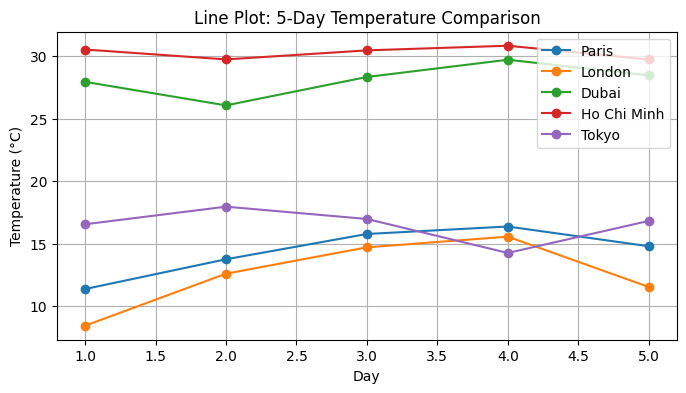

In [3]:
import tkinter as tk  # GUI toolkit
from tkinter import messagebox  # For showing alerts
import requests  # For API requests
import matplotlib.pyplot as plt  # For plotting
import numpy as np  # For handling and averaging temperature data
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg  # For embedding matplotlib plots in Tkinter


# OpenWeatherMap API key
API_KEY = "43491c87baaa0e8101798dab9f23c10c"

# Global lists to store cities and their temperature data
all_data = []
all_cities = []

# Function to get 5-day average temperature for a city
def get_daily_avg_data(city):
    url = f"https://api.openweathermap.org/data/2.5/forecast?q={city}&appid={API_KEY}&units=metric"
    response = requests.get(url)

    if response.status_code != 200:
        return None

    data = response.json()
    temps = [entry['main']['temp'] for entry in data['list']]  # Get temperature from every 3-hour forecast
    temps_np = np.array(temps).reshape(-1, 8)  # Reshape to 5 days x 8 readings/day
    daily_avg = np.mean(temps_np, axis=1)  # Compute daily averages
    return daily_avg

# Function to add a city card to the GUI
def on_add_city():
    city = city_entry.get().strip()
    if not city:
        return

    daily_avg = get_daily_avg_data(city)
    if daily_avg is None:
        messagebox.showerror("Error", f"Failed to retrieve data for {city}")
        return

    all_cities.append(city)
    all_data.append(daily_avg)

    # Determine position (2 cards per row)
    index = len(all_cities) - 1
    row = index // 2
    col = index % 2

    # Create frame for this city card
    display_frame = tk.Frame(scrollable_frame, bg="#ffffff", bd=2, relief="ridge", padx=10, pady=10)
    display_frame.grid(row=row, column=col, padx=10, pady=10, sticky="nsew")

    # Title label for city
    city_title = tk.Label(display_frame, text=f"📍 {city}", font=("Helvetica", 13, "bold"), fg="#333", bg="#ffffff")
    city_title.pack(anchor="w")

    # Display average temps for 5 days
    temps_text = ""
    for day, temp in enumerate(daily_avg, 1):
        temps_text += f"Day {day}: {temp:.1f}°C\n"

    temps_label = tk.Label(display_frame, text=temps_text.strip(), justify="left", font=("Helvetica", 11), bg="#ffffff", fg="#555")
    temps_label.pack(anchor="w")

    # Clear input after adding
    city_entry.delete(0, tk.END)

# Function to generate the line plot temperature comparison plot
def on_compare():
    if len(all_data) < 2:
        messagebox.showinfo("Info", "Add at least two cities to compare.")
        return

    # Create a new window for the plot
    plot_window = tk.Toplevel(root)
    plot_window.title("Parallel Temperature Comparison")

    fig, ax = plt.subplots(figsize=(8, 4))
    for i, temps in enumerate(all_data):
        ax.plot(range(1, 6), temps, marker='o', label=all_cities[i])  # Plot 5 days of temps

    ax.set_title("Line Plot: 5-Day Temperature Comparison")
    ax.set_xlabel("Day")
    ax.set_ylabel("Temperature (°C)")
    ax.grid(True)
    ax.legend(loc='upper right')

    # Embed the plot into the Tkinter window
    canvas = FigureCanvasTkAgg(fig, master=plot_window)
    canvas.draw()
    canvas.get_tk_widget().pack(padx=10, pady=10)


# ------------------------ GUI SETUP ------------------------

# Create the main window
root = tk.Tk()
root.title("City Temperature Comparison")
root.geometry("480x600")
root.configure(bg="#f5f5f5")

# Label and input for entering city name
tk.Label(root, text="Enter City Name", font=("Helvetica", 12), bg="#f5f5f5").pack(pady=(10, 0))
city_entry = tk.Entry(root, font=("Helvetica", 12))
city_entry.pack(pady=5)

# Button to add city
tk.Button(root, text="Add City", command=on_add_city, font=("Helvetica", 11, "bold"),
          bg="#4CAF50", fg="white", padx=10).pack(pady=5)

# Button to generate comparison plot
tk.Button(root, text="Generate Comparison Plot", command=on_compare, font=("Helvetica", 11, "bold"),
          bg="#2196F3", fg="white", padx=10).pack(pady=5)

# Scrollable canvas to hold city cards
canvas = tk.Canvas(root, height=400, bg="#eaeaea", highlightthickness=0)
scrollbar = tk.Scrollbar(root, orient="vertical", command=canvas.yview)
scrollable_frame = tk.Frame(canvas, bg="#eaeaea")

# Set up the scroll region
scrollable_frame.bind(
    "<Configure>",
    lambda e: canvas.configure(scrollregion=canvas.bbox("all"))
)

# Two-column layout for city cards
scrollable_frame.columnconfigure(0, weight=1)
scrollable_frame.columnconfigure(1, weight=1)

# Place the inner frame inside the canvas
canvas.create_window((0, 0), window=scrollable_frame, anchor="nw")
canvas.configure(yscrollcommand=scrollbar.set)

# Pack canvas and scrollbar
canvas.pack(side="left", fill="both", expand=True, padx=(10, 0), pady=10)
scrollbar.pack(side="right", fill="y")

# Start the GUI loop
root.mainloop()
